In [1]:
# Author: Guoqing Bao
# School of Computer Science, The University of Sydney
# Date: 2019-12-12
# GitHub Project Link: https://github.com/guoqingbao/Pathofusion
# Please cite our work if you found it is useful for your research or clinical practice


import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = 10000000000
import cv2
import sqlite3
%matplotlib inline
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import pandas as pd
import cv2
from urllib.request import urlopen
import io
import gc
gc.enable()

# import helper function (database manupulation, image augmentation, plot performance, train, etc.)
from project.models.helper import *
# import our BCNN from models
from project.models.bcnn import BCNN

Using TensorFlow backend.


# Prepare whole-slide images and model

In [2]:
GRADE = 4
PATIENT_ID = 11 # remember to change this when you prediction other whole-slide images
image_name = "Image_P" + str(PATIENT_ID) # the  whole-slide image file name that we will predict
image_path = "http://xx.xx.xx.xx/static/labelling/" #it's path, we just uploaded them under the website static path
image_file = image_path + image_name + ".jpg"

urlsession = urlopen(image_file)
image_io = io.BytesIO(urlsession.read())  
img_origin = Image.open(image_io)
w = img_origin.width
h = img_origin.height

x = 512/2
y = 512/2

In [3]:
stride = 50

cols = int((w - 512)/stride) - int(256/stride)
rows = int((h - 512)/stride) - int(256/stride)

print("Width={}, height={}, start from (x={}, y={}), stride={}, total rows={}, total columns={})".format(w, h, x, y,stride, rows, cols))

Width=22273, height=19602, start from (x=256.0, y=256.0), stride=50, total rows=376, total columns=430)


In [4]:
project_path = './project/brain/'
path = project_path + "results/prediction/"
model_path = project_path + "results/bcnn/"

In [5]:
# load trained model
model = BCNN(6)
model = nn.DataParallel(model).cuda()

checkPoint = torch.load(model_path + 'torch_model.h5')
model.load_state_dict(checkPoint)
print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

Number of model parameters: 11617382


In [6]:
# to re-predict the whole-slide images, you may delete prediction_index files (under results/prediction), otherwise it will use the existed prediction results
total = rows * cols
progress = 0
prediction_array = None
intensity_array = []

start_row = 0

try:
    with open(path + 'prediction_index'+str(PATIENT_ID) + '.txt', 'r') as f:
        prediction_array = np.load(path + 'prediction_array' +str(PATIENT_ID) + '.npy')
        num = f.readline()
        f.close()
        start_row = int(num) + 1
        print("Row start from {}".format(start_row))
except OSError:
    print("file not found")

file not found


# Prediction of the whole-slide images (patch by patch approach)

In [1]:
model.eval()

# let's predict the whole-slide image patch by patch
# cropped from up-left to bottom-right

for row in range(start_row,rows):
    crop_images_256 = []
    crop_images_512 = []
#     print("Processing (row {})...".format(row))
    for col in range(cols):
        seq = row * cols + col
        xx1 = int(x + col * stride)
        yy1 = int(y + row * stride)
        
        # crop two resolution image patches
        img_256 = img_origin.crop((xx1,yy1,xx1 + 256,yy1 + 256)) # (left, upper, right, lower)-tuple.
        crop_images_256.append(np.asarray(img_256)/255)
        
        xx2, yy2 = int(xx1-128), int(yy1-128)
        img_512 = img_origin.crop((xx2,yy2,xx2 + 512,yy2 + 512)) # (left, upper, right, lower)-tuple.
        crop_images_512.append(np.asarray(img_512)/255)
        
        intensity_array.append((np.mean(img_256) + np.mean(img_512))/2)
        
        del img_256, img_512
        
    tests_array_256 = np.array(crop_images_256, dtype='float32')
    tests_array_512 = np.array(crop_images_512, dtype='float32')
    tests_array_256 = np.transpose(tests_array_256, (0, 3,1,2))
    tests_array_512 = np.transpose(tests_array_512, (0, 3,1,2))
    pred = []
    # predict one row at each iteration
    for i in range(int(cols/100) + 1):
        with torch.no_grad():
            a = tests_array_256[i*100:(i+1)*100]
            b = tests_array_512[i*100:(i+1)*100]
            m1, m2 = Variable(torch.FloatTensor(a).cuda()), Variable(torch.FloatTensor(b).cuda())
            yret = model(m1, m2)
            pred.extend(F.softmax(yret).cpu().numpy().tolist())
    ret = np.array(pred)


    if row == 0:
        prediction_array = ret
    else:
        prediction_array = np.vstack([prediction_array, ret])
        
    #save prediction     
    np.save(path + 'prediction_array'+str(PATIENT_ID) + '.npy',prediction_array)
    np.save(path + 'intensity_array'+str(PATIENT_ID) + '.npy',intensity_array)
    
    with open(path + 'prediction_index'+str(PATIENT_ID) + '.txt', 'w') as f:
        f.write('%d' % row)
        f.close()
        
    del tests_array_256
    del tests_array_512         
    del crop_images_256
    del crop_images_512
    gc.collect()
    pg = int(row/rows * 100)
    if pg != progress:
        progress = pg
        print('Processed {}% '.format(progress))    

Processed 1% 
Processed 2% 
Processed 3% 
Processed 4% 
Processed 5% 
Processed 6% 
Processed 7% 
Processed 8% 
Processed 9% 
Processed 10% 
Processed 11% 
Processed 12% 
Processed 13% 
Processed 14% 
Processed 15% 
Processed 16% 
Processed 17% 
Processed 18% 
Processed 19% 
Processed 20% 
Processed 21% 
Processed 22% 
Processed 23% 
Processed 24% 
Processed 25% 
Processed 26% 
Processed 27% 
Processed 28% 
Processed 29% 
Processed 30% 
Processed 31% 
Processed 32% 
Processed 33% 
Processed 34% 
Processed 35% 
Processed 36% 
Processed 37% 
Processed 38% 
Processed 39% 
Processed 40% 
Processed 41% 
Processed 42% 
Processed 43% 
Processed 44% 
Processed 45% 
Processed 46% 
Processed 47% 
Processed 48% 
Processed 49% 
Processed 50% 
Processed 51% 
Processed 52% 
Processed 53% 
Processed 54% 
Processed 55% 
Processed 56% 
Processed 57% 
Processed 58% 
Processed 59% 
Processed 60% 
Processed 61% 
Processed 62% 
Processed 63% 
Processed 64% 
Processed 65% 
Processed 66% 
Processed 67% 
Proc

In [7]:
#load prediction results
prediction_array = np.load(path + 'prediction_array'+str(PATIENT_ID) + '.npy')
intensity_array = np.load(path + 'intensity_array'+str(PATIENT_ID) + '.npy')

In [8]:
d_intensity = np.array(intensity_array)
bk_position = np.where(d_intensity>230)[0].tolist()

In [9]:
#1 Necrosis-palisading, 2 MicVas-Proliferation, 3 Blood-Vessel, 4 Necrosis-Geo, 5 Brain-Tissue, 6 Tumor, 7 Satellitosis (tiny)
# color_types = {1:'black', 2:'yellow', 3:'blue', 4:'cyan',5:'grey', 6:'green', 7:'purple'}

colors = []

colors.append([1,0,0]) #red necrosis palisading
colors.append([0,0,1]) #blue MicVas-Proliferation
colors.append([0,1,1]) #cyan blood-vessel

colors.append([1,1,0]) #yellow Necrosis-Geo
colors.append([1,1,1])# white Magenta  5 Brain-Tissue

colors.append([0,0.7,0.7]) #green tumor background

In [10]:
typeret = np.argmax(prediction_array,axis=1)
typeret = typeret + 1
typeret[bk_position]=0
totalArea = np.sum(typeret!=0)
totalArea

94630

In [11]:
counts = []
for i in range(6):
    counts.append(np.sum(typeret==i+1))

In [12]:
pd.DataFrame(counts, columns=['Type']).T

,0,1,2,3,4,5
Type,11606,12648,2426,17870,188,49892


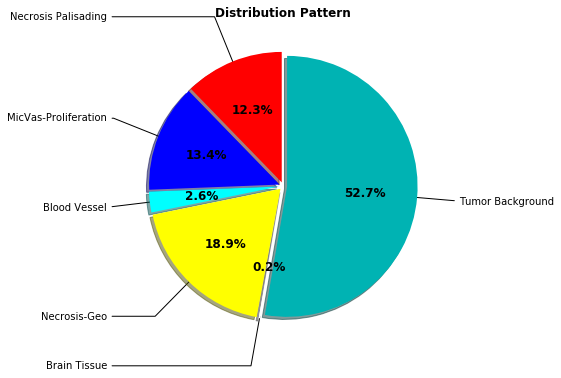

In [13]:
#1 Necrosis-palisading, 2 MicVas-Proliferation, 3 Blood-Vessel, 4 Necrosis-Geo, 5 Brain-Tissue, 6 Tumor background
#let's see distribution of the predicted results
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))

pie_chart_exploded = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03)
wedges, texts, autotexts = ax.pie(counts, autopct='%1.1f%%', explode=pie_chart_exploded,  shadow=True, startangle=90, 
                                  colors=colors,
                                  textprops=dict(color="black"))
labels = ["Necrosis Palisading","MicVas-Proliferation","Blood Vessel","Necrosis-Geo","Brain Tissue","Tumor Background"]

plt.setp(autotexts, size=12, weight="bold")

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)
    
ax.set_title("Distribution Pattern",size=12, weight="bold")
plt.savefig(path + 'distribution_pattern'+str(PATIENT_ID)+ '.svg',format='svg')
plt.show()

# Multimodal histopathology image fusion

## 1. Convert to color heatmap

In [14]:
colors = np.array(colors)
predicts = []
predicts_bin = []

for item in prediction_array:
    predicts.append(colors[np.argmax(item)] * np.max(item))
    predicts_bin.append(colors[np.argmax(item)] * 1.0)

predicts = np.array(predicts)    
predicts_bin = np.array(predicts_bin)   

True

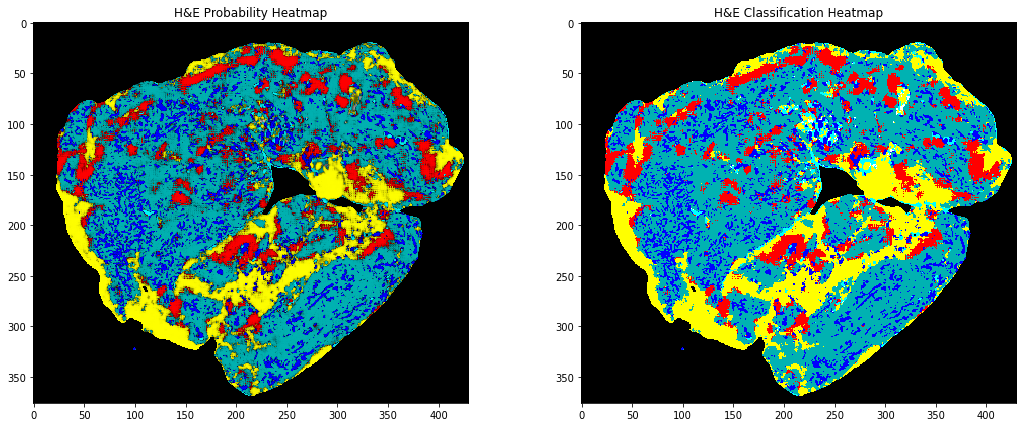

In [15]:
# color-mapping, plot the heatmap
r_channel = predicts[:,0] 
r_channel[bk_position] = 0
g_channel = predicts[:,1] 
g_channel[bk_position] = 0
b_channel = predicts[:,2] 
b_channel[bk_position] = 0
r = r_channel.reshape(rows,cols)
g = g_channel.reshape(rows,cols)
b = b_channel.reshape(rows,cols)

heatmap = cv2.merge([r, g,b])
cv2.imwrite(path + 'brain_heatmap'+str(PATIENT_ID) +'.bmp', cv2.merge([b, g,r])*256)

r_channel = predicts_bin[:,0] 
r_channel[bk_position] = 0
g_channel = predicts_bin[:,1] 
g_channel[bk_position] = 0
b_channel = predicts_bin[:,2] 
b_channel[bk_position] = 0
r = r_channel.reshape(rows,cols)
g = g_channel.reshape(rows,cols)
b = b_channel.reshape(rows,cols)

heatmap_bin = cv2.merge([r, g,b])

fig, ax = plt.subplots(1,2, figsize=(18, 7))

ax[0].imshow(heatmap)
ax[0].title.set_text("H&E Probability Heatmap")
ax[1].imshow(heatmap_bin)
ax[1].title.set_text("H&E Classification Heatmap")
plt.savefig(path + 'probability_vs_classification'+str(PATIENT_ID)+ '.svg',format='svg')

plt.savefig(path + 'brain_heatmap'+str(PATIENT_ID)+ '.svg',format='svg')

cv2.imwrite(path + 'brain_heatmap_bin'+str(PATIENT_ID) +'.bmp', cv2.merge([b, g,r])*255)

# Upload predicted heatmap to labelling website

In [16]:
# Upload the above heatmap to your labelling website (WebLabelling/labelling/static/labelling) to see how heatmap overlaid on H&E images.
# Please make sure the name of the heatmap changed to Image_Pxx_Heatmap.bmp, Image_Pxx is the name of corresponding H&E image.

## 2. Heatmap registration (alignment)

In [17]:
im1 =  cv2.imread(path + 'brain_heatmap_bin' + str(PATIENT_ID) + '.bmp' )
im2 =  cv2.imread(project_path + 'results/prediction_cd276/brain_cd276_heatmap_bin' + str(PATIENT_ID) + '.bmp')
im22 =  cv2.imread(project_path + 'results/prediction_cd276/brain_cd276_heatmap' + str(PATIENT_ID) + '.bmp')
heatmap =  cv2.imread(path + 'brain_heatmap' + str(PATIENT_ID) + '.bmp' )

In [18]:
# image registration
im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im1_gray[im1_gray >0] = 128
im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
im2_gray[im2_gray >0] = 128

sz = im1.shape
warp_mode = cv2.MOTION_HOMOGRAPHY

if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

number_of_iterations = 5000;
termination_eps = 1e-10;
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)
 
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);


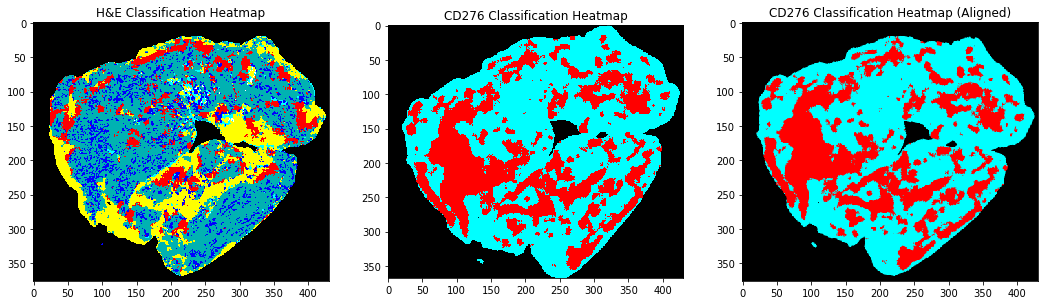

In [19]:
#let's see cd276 heatmap after alignment
fig, ax = plt.subplots(1,3, sharex=True, figsize=(18,6))
ax[0].imshow(np.array(cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)))
ax[0].title.set_text("H&E Classification Heatmap")
ax[1].imshow(np.array(cv2.cvtColor(im2, cv2.COLOR_RGB2BGR)))
ax[1].title.set_text("CD276 Classification Heatmap")
ax[2].imshow(np.array(cv2.cvtColor(im2_aligned, cv2.COLOR_RGB2BGR)))
ax[2].title.set_text("CD276 Classification Heatmap (Aligned)")
plt.savefig(path + 'merged_process'+str(PATIENT_ID)+ '.svg',format='svg') 

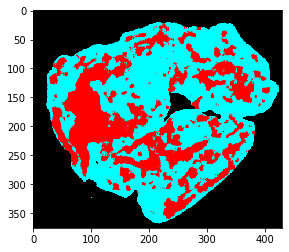

In [20]:
#we need to remove regions in cd276 heatmap that not included in h&e heatmap

gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
_,mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY);
im2_aligned1 = cv2.cvtColor(im2_aligned, cv2.COLOR_RGB2BGR)

im2_aligned_excluded = cv2.bitwise_and(im2_aligned1, im2_aligned1, mask=mask)

plt.imshow(im2_aligned_excluded)

In [21]:
im2_aligned_excluded = np.round(im2_aligned_excluded/255.0,0).astype(np.uint8)*int(255) #repair cd276 heatmap (registration introduced noise)

In [22]:
cv2.imwrite(path + 'brain_cd276_heatmap_aligned_bin' + str(PATIENT_ID) + '.bmp', cv2.cvtColor(im2_aligned_excluded,cv2.COLOR_BGR2RGB))

True

## 3. Fusion of the corresponding heatmaps

True

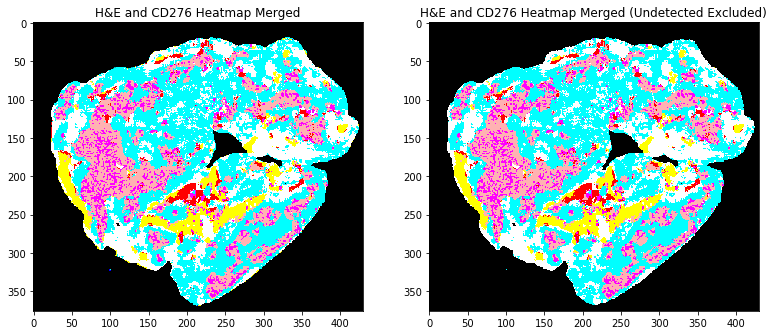

In [23]:
im2_aligned_excluded1 = cv2.cvtColor(im2_aligned_excluded, cv2.COLOR_BGR2RGB)
combined = im1 | im2_aligned_excluded1
bgrCombined = cv2.cvtColor(combined, cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(im2_aligned_excluded,cv2.COLOR_BGR2GRAY)
_,mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY);

bgrCombined_excluded = cv2.bitwise_and(bgrCombined, bgrCombined, mask=mask)
fig, ax = plt.subplots(1,2, sharex=True, figsize=(13,6))
ax[0].imshow(bgrCombined)
ax[0].title.set_text("H&E and CD276 Heatmap Merged")
ax[1].imshow(bgrCombined_excluded)
ax[1].title.set_text("H&E and CD276 Heatmap Merged (Undetected Excluded)")
cv2.imwrite(path + 'brain_heatmap_merge_bin' + str(PATIENT_ID) + '.bmp', cv2.cvtColor(bgrCombined_excluded,cv2.COLOR_BGR2RGB))

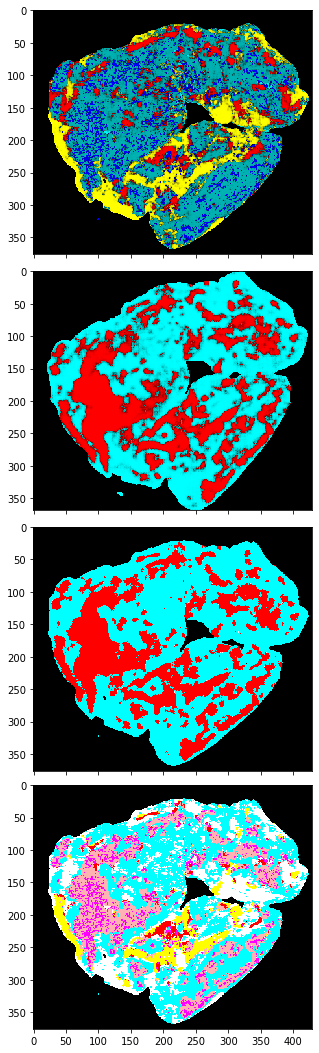

In [24]:
fig, ax = plt.subplots(4,1, figsize=(5,19), sharex='col', sharey='row')
fig.subplots_adjust(wspace=0.001, hspace=0.001)
ax[0].imshow(np.array(cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)) )
# ax[0].title.set_text("H&E Classification")

ax[1].imshow(np.array(cv2.cvtColor(im22, cv2.COLOR_RGB2BGR)))
# ax[1].title.set_text("CD276 Expression")

ax[2].imshow(im2_aligned_excluded)
# ax[2].title.set_text("CD276 Expression (Aligned)")

ax[3].imshow(bgrCombined_excluded)
# ax[3].title.set_text("H&E and CD276 Correlation")
# plt.tight_layout()
plt.savefig(path + 'side_by_side'+str(PATIENT_ID)+ '.png',format='png')

# Quantatitive analysis

In [25]:
colors_merged = []

colors_merged.append([1,0,0]) # necrosis palisading + positive  --> (red)
colors_merged.append([1,0,1]) # MicVas-Proliferation + positive --> (magenta)
colors_merged.append([1,1,1]) # Necrosis Palisading, Necrosis-Geo or Brain-Tissue + Negative / blood-vessel or Brain-Tissue + positive  -->(white) 
colors_merged.append([1,1,0]) #Necrosis-Geo + positive --> (yellow)

colors_merged.append([1,0.7,0.7]) #tumor background + positive (rgb(255,178,178))

colors_merged.append([0,1,1]) #tumor background + negative, MicVas-Proliferation + negative , # blood-vessel + negative --> (cyan)

In [26]:
gray = cv2.cvtColor(bgrCombined_excluded,cv2.COLOR_BGR2GRAY)
_,allMask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY);
total = np.sum(allMask==255) #total pixels excludes picture black background

In [27]:
labels = ["Necrosis Palisading \n+ CD276 Positive","MicVas-Proliferation \n+ CD276 Positive",
          "Necrosis Palisading, \nNecrosis-Geo or Brain-Tissue \n+ CD276 Negative \n/ Blood Vessel or Brain Tissue \n+ CD276 Positive",
          "Necrosis-Geo \n+ CD276 Positive", 
          "Tumor Background \n+ CD276 Positive",
          "Tumor Background, \nMicVas-Proliferation or\n Blood-vessel + CD276 Negative"]

HSV color range: [115  90 130] [125 255 255]  account 2.76%
HSV color range: [145  90 130] [155 255 255]  account 8.02%
HSV color range: [  0   0 100] [255  50 255]  account 22.81%
HSV color range: [ 85  90 130] [ 95 255 255]  account 6.37%
HSV color range: [115  57 100] [125 107 255]  account 19.44%
HSV color range: [ 25  90 130] [ 35 255 255]  account 40.61%


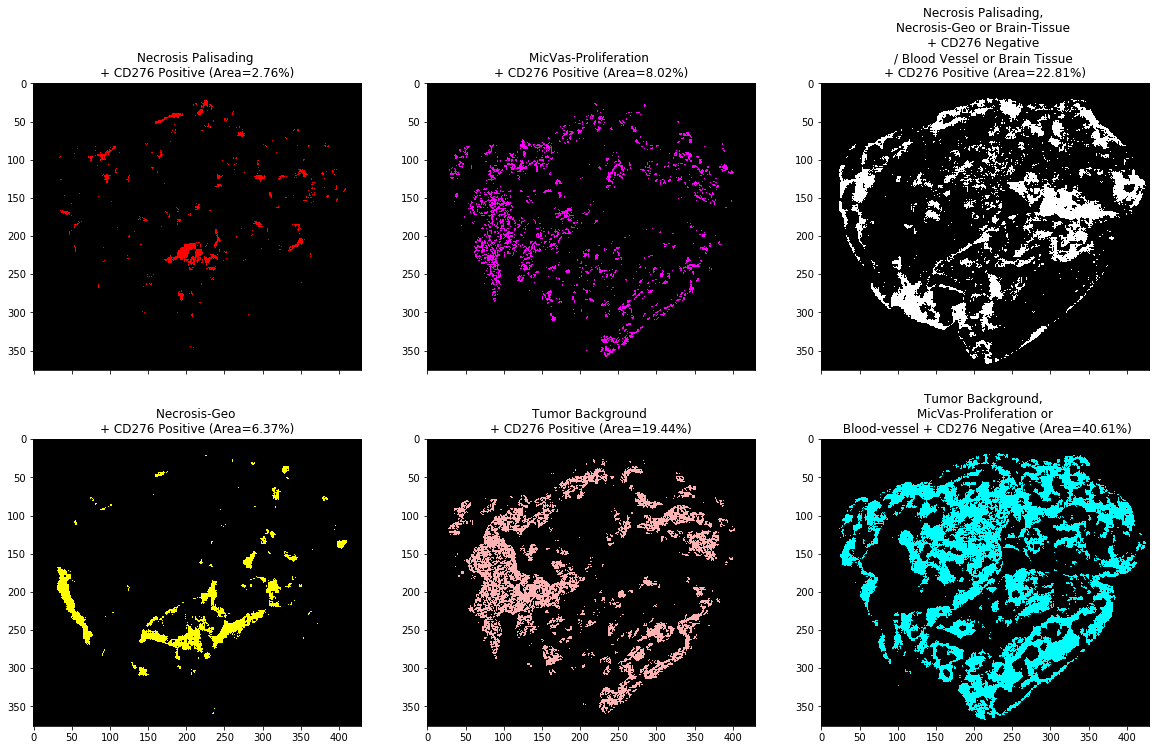

In [28]:
counts1 = []
rets = []
fig, ax = plt.subplots(2,3, sharex=True, figsize=(20,12))
index = 0
for color in colors_merged:    
    c = np.uint8([[color]])
    hsv_c = cv2.cvtColor(c,cv2.COLOR_BGR2HSV)
    hsv = cv2.cvtColor(bgrCombined_excluded, cv2.COLOR_BGR2HSV)
    hue_low = hsv_c[0][0][0]-5
    if hue_low <0:
        hue_low = 0
    hue_high = hsv_c[0][0][0]+5
    if color == [1,1,1]:   
        lower = np.array([0,0,100])
        upper = np.array([255,50,255])
    elif color == [1,0.7,0.7]:
        lower = np.array([hue_low,77-20,100])
        upper = np.array([hue_high,77+30,255])    
        
    else:
        lower = np.array([hue_low,90,130])
        upper = np.array([hue_high,hsv_c[0][0][1],255])

    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(bgrCombined_excluded,bgrCombined_excluded, mask= mask)
    rets.append(res)
    counts1.append(np.sum(mask==255))
    print("HSV color range:", lower, upper, " account {0:.2f}%".format(np.sum(mask==255)/total*100))
    if int(index/3) <2:
        ax[int(index/3),index%3].imshow(res)
        ax[int(index/3),index%3].title.set_text(labels[index] +" (Area={0:.2f}%)".format(np.sum(mask==255)/total*100))
    index += 1
plt.savefig(path + 'merged_separation'+str(PATIENT_ID)+ '.svg',format='svg')
plt.show()


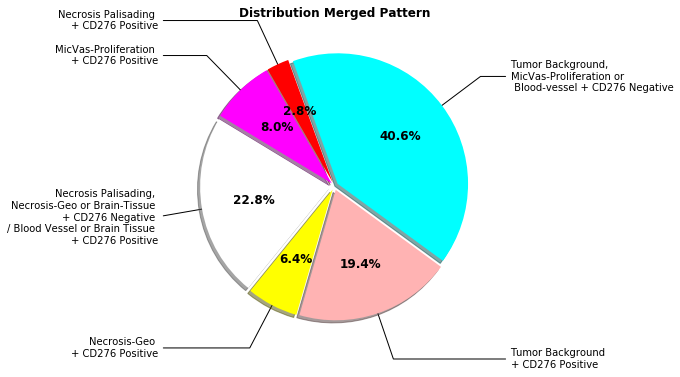

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

pie_chart_exploded = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03)
wedges, texts, autotexts = ax.pie(counts1, autopct='%1.1f%%', explode=pie_chart_exploded,  shadow=True, startangle=110, 
                                  colors=colors_merged,
                                  textprops=dict(color="black"))

plt.setp(autotexts, size=12, weight="bold")
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)
    
ax.set_title("Distribution Merged Pattern",size=12, weight="bold")
plt.savefig(path + 'distribution_merge_pattern'+str(PATIENT_ID)+ '.svg',format='svg')
plt.show()